<a href="https://colab.research.google.com/github/Mohammad-Zahed-Hossen/ImageProcessingPlayground-Repo/blob/main/MalariaParaciteDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install TensorFlow, datasets, and utilities
!pip install tensorflow tensorflow-datasets matplotlib scikit-learn opencv-python-headless -q

print("✅ All dependencies installed successfully!")


✅ All dependencies installed successfully!


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler
import cv2
import warnings

warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)


In [ ]:
train_ds, val_ds, test_ds = tfds.load(
    'malaria',
    split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'],
    as_supervised=True,)

print(f"✅ Dataset loaded from TFDS (27,558 total images)")
print(f"Train samples: ~19,291 (70%)")
print(f"Validation samples: ~4,134 (15%)")
print(f"Test samples: ~4,133 (15%)")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/incomplete.SGJ3GO_1.0.0/malaria-train.tfrecord*...:   0%|         …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.
✅ Dataset loaded from TFDS (27,558 total images)
Train samples: ~19,291 (70%)
Validation samples: ~4,134 (15%)
Test samples: ~4,133 (15%)


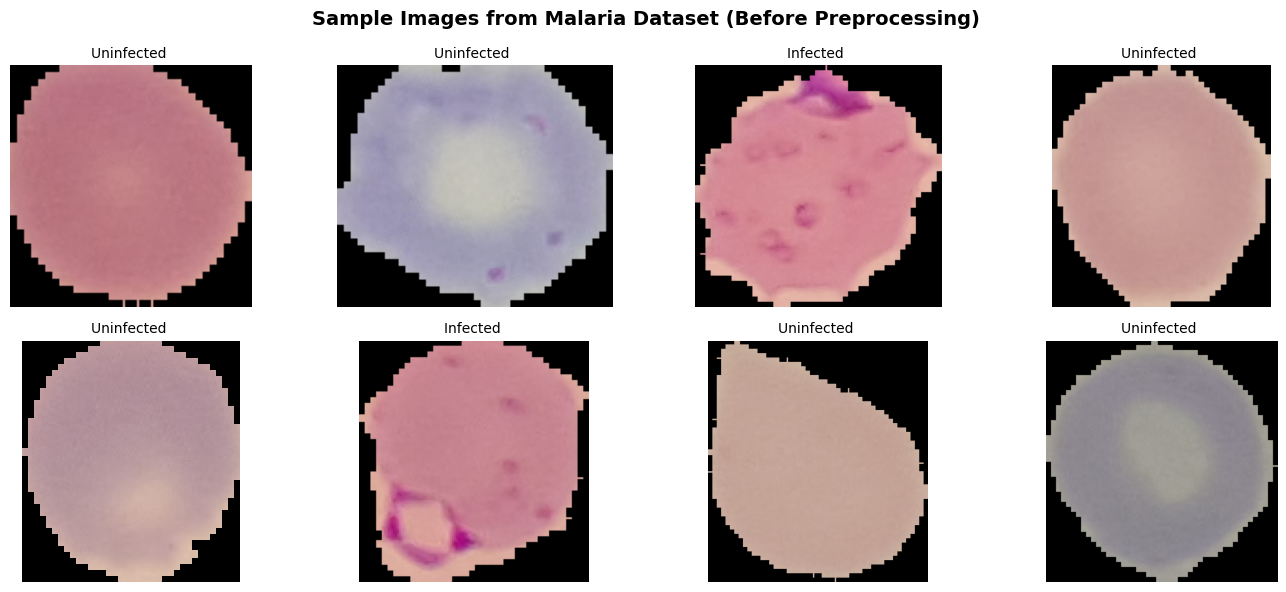

Image dimensions: Original images are 48×48 (uint8 format)


In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(14, 6))
fig.suptitle('Sample Images from Malaria Dataset (Before Preprocessing)', fontsize=14, fontweight='bold')

for idx, (img, label) in enumerate(train_ds.take(8)):
    ax = axes[idx // 4, idx % 4]

    ax.imshow(img.numpy())

    label_text = "Infected " if label.numpy() == 0 else "Uninfected "
    ax.set_title(label_text, fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

print("Image dimensions: Original images are 48×48 (uint8 format)")

In [ ]:
# Count class distribution
train_infected = sum(1 for _, label in train_ds if label == 1)
train_uninfected = sum(1 for _, label in train_ds if label == 0)

val_infected = sum(1 for _, label in val_ds if label == 1)
val_uninfected = sum(1 for _, label in val_ds if label == 0)

test_infected = sum(1 for _, label in test_ds if label == 1)
test_uninfected = sum(1 for _, label in test_ds if label == 0)

print("=" * 60)
print("CLASS DISTRIBUTION")
print("=" * 60)
print(f"\nTraining Set ({train_infected + train_uninfected} samples):")
print(f"  Uninfected: {train_uninfected:,} ({100*train_uninfected/(train_infected+train_uninfected):.1f}%)")
print(f"  Infected:   {train_infected:,} ({100*train_infected/(train_infected+train_uninfected):.1f}%)")

print(f"\nValidation Set ({val_infected + val_uninfected} samples):")
print(f"  Uninfected: {val_uninfected:,} ({100*val_uninfected/(val_infected+val_uninfected):.1f}%)")
print(f"  Infected:   {val_infected:,} ({100*val_infected/(val_infected+val_uninfected):.1f}%)")

print(f"\nTest Set ({test_infected + test_uninfected} samples):")
print(f"  Uninfected: {test_uninfected:,} ({100*test_uninfected/(test_infected+test_uninfected):.1f}%)")
print(f"  Infected:   {test_infected:,} ({100*test_infected/(test_infected+test_uninfected):.1f}%)")
print("=" * 60)


CLASS DISTRIBUTION

Training Set (19291 samples):
  Uninfected: 9,641 (50.0%)
  Infected:   9,650 (50.0%)

Validation Set (4133 samples):
  Uninfected: 2,052 (49.6%)
  Infected:   2,081 (50.4%)

Test Set (4134 samples):
  Uninfected: 2,086 (50.5%)
  Infected:   2,048 (49.5%)


In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32

def preprocess_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))

    # image = tf.cast(image, tf.float32) / 255.0

    return image, label

print("✅ Preprocessing function defined")
print(f"   Input: 48×48 uint8 image")
print(f"   Output: {IMG_SIZE}×{IMG_SIZE} float32 image [0, 1]")


✅ Preprocessing function defined
   Input: 48×48 uint8 image
   Output: 224×224 float32 image [0, 1]


In [ ]:
train_ds_preprocessed = (
    train_ds
    .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(buffer_size=2000)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

val_ds_preprocessed = (
    val_ds
    .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

test_ds_preprocessed = (
    test_ds
    .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
)

print("✅ Preprocessing pipeline applied")
print(f"   Train batches: batch_size={BATCH_SIZE}, shuffled, prefetched")
print(f"   Val batches: batch_size={BATCH_SIZE}, prefetched")
print(f"   Test batches: batch_size={BATCH_SIZE}")


✅ Preprocessing pipeline applied
   Train batches: batch_size=32, shuffled, prefetched
   Val batches: batch_size=32, prefetched
   Test batches: batch_size=32


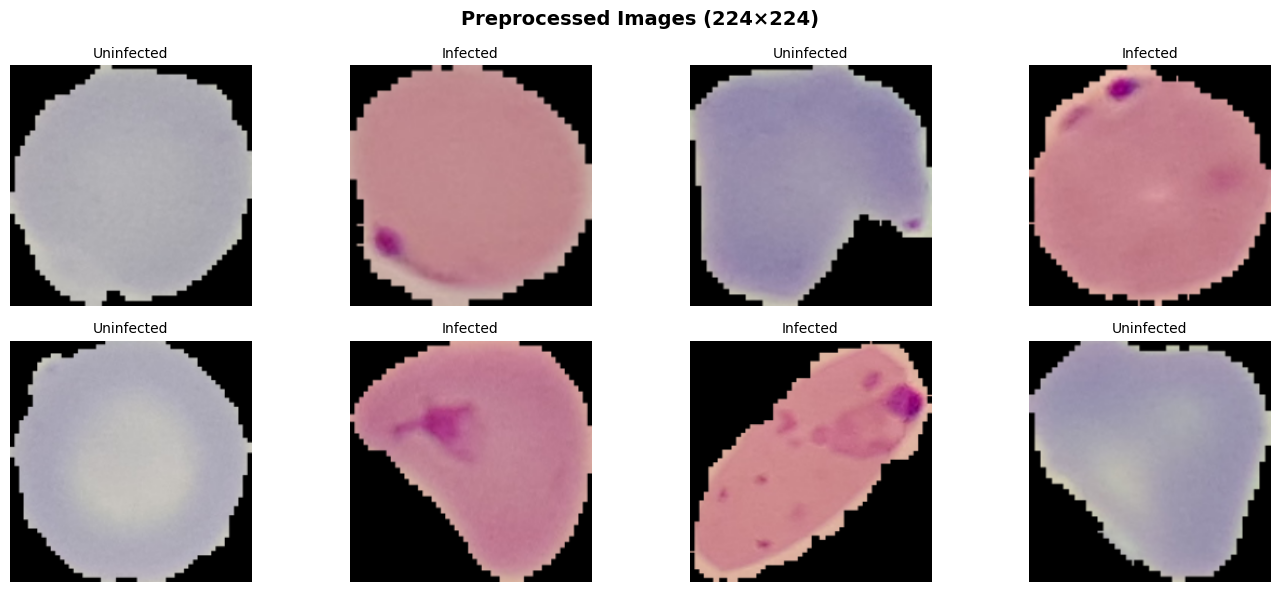

Image shape after preprocessing: (32, 224, 224, 3)
Pixel value range: [0.000, 240.055]


In [32]:
fig, axes = plt.subplots(2, 4, figsize=(14, 6))
fig.suptitle('Preprocessed Images (224×224)', fontsize=14, fontweight='bold')

for idx, (images, labels) in enumerate(train_ds_preprocessed.take(1)):
    for i in range(8):
        ax = axes[i // 4, i % 4]

        img = images[i]
        img_to_show = tf.clip_by_value(img, 0.0, 255.0)
        img_to_show = tf.cast(img_to_show, tf.uint8)

        ax.imshow(img_to_show.numpy())
        label_text = "Infected" if labels[i].numpy() == 0 else "Uninfected"
        ax.set_title(label_text, fontsize=10)
        ax.axis('off')

plt.tight_layout()
plt.show()

print(f"Image shape after preprocessing: {images.shape}")
print(f"Pixel value range: [{images.numpy().min():.3f}, {images.numpy().max():.3f}]")


In [ ]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomContrast, RandomBrightness

data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomContrast(0.1),
    RandomBrightness(0.1),
])

print(" Data augmentation layer created with:")
print("   - RandomFlip (horizontal)")
print("   - RandomRotation (±10%)")
print("   - RandomContrast (±10%)")
print("   - RandomBrightness (±10%)")


 Data augmentation layer created with:
   - RandomFlip (horizontal)
   - RandomRotation (±10%)
   - RandomContrast (±10%)
   - RandomBrightness (±10%)


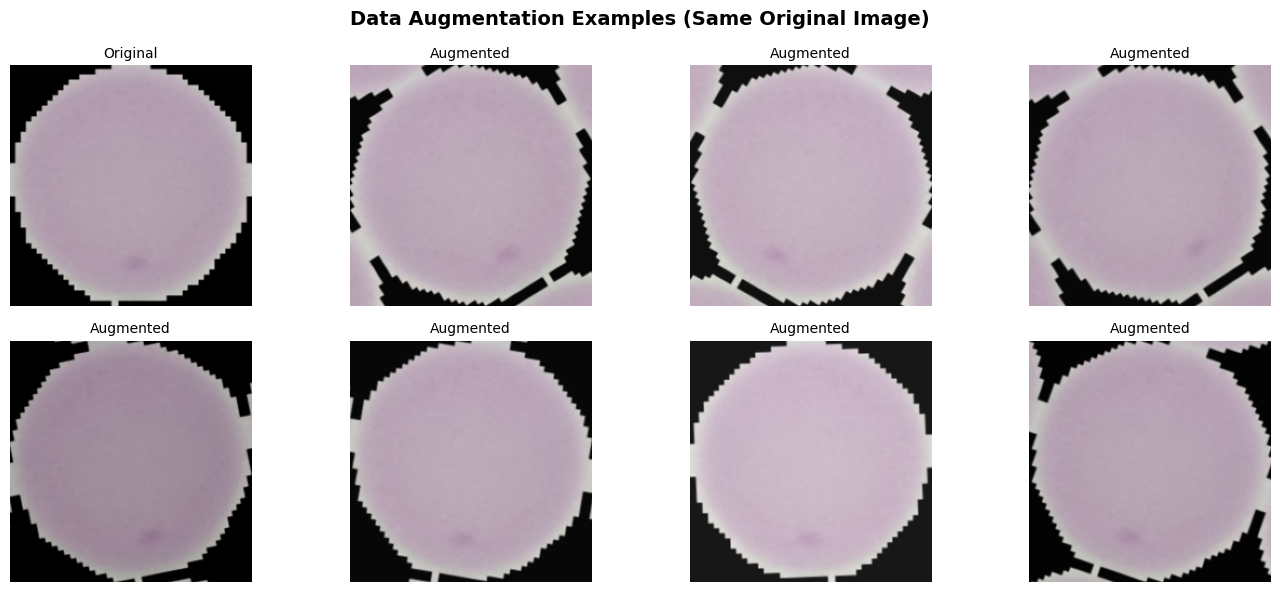

In [30]:
fig, axes = plt.subplots(2, 4, figsize=(14, 6), squeeze=False)
fig.suptitle('Data Augmentation Examples (Same Original Image)',
             fontsize=14, fontweight='bold')

for images, labels in train_ds_preprocessed.take(1):
    original_single_image = images[0]

    # Original
    ax = axes[0, 0]
    orig_to_show = tf.clip_by_value(original_single_image, 0.0, 255.0)
    orig_to_show = tf.cast(orig_to_show, tf.uint8)
    ax.imshow(orig_to_show.numpy())
    ax.set_title("Original", fontsize=10)
    ax.axis('off')

    # 7 augmented versions
    for i in range(1, 8):
        ax = axes[i // 4, i % 4]

        augmented = data_augmentation(
            tf.expand_dims(original_single_image, axis=0),
            training=True
        )[0]

        aug_to_show = tf.clip_by_value(augmented, 0.0, 255.0)
        aug_to_show = tf.cast(aug_to_show, tf.uint8)
        ax.imshow(aug_to_show.numpy())
        ax.set_title("Augmented", fontsize=10)
        ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

print(f"✅ MobileNetV2 backbone loaded")
print(f"   Trainable layers: {len([l for l in base_model.layers if l.trainable])}")
print(f"   Frozen layers: {len([l for l in base_model.layers if not l.trainable])}")


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
✅ MobileNetV2 backbone loaded
   Trainable layers: 0
   Frozen layers: 154


In [ ]:
# Build full model with custom head
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Apply data augmentation (only during training)
x = data_augmentation(inputs)

# Apply MobileNetV2 backbone
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)

# Global average pooling (compress spatial dimensions)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Dropout (regularization to prevent overfitting)
x = tf.keras.layers.Dropout(0.3)(x)

# Dense layer for learned features
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)

# Output layer: sigmoid for binary classification
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Create model
model = tf.keras.Model(inputs, outputs)

print("✅ Model architecture assembled")
print("\nModel Summary:")
model.summary()


✅ Model architecture assembled

Model Summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Compile with Adam optimizer and binary cross-entropy loss
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

print("✅ Model compiled")
print("   Optimizer: Adam (lr=1e-3)")
print("   Loss: Binary Cross-Entropy")
print("   Metrics: Accuracy, Precision, Recall")


✅ Model compiled
   Optimizer: Adam (lr=1e-3)
   Loss: Binary Cross-Entropy
   Metrics: Accuracy, Precision, Recall


In [ ]:
print("\n" + "="*70)
print("STAGE 1: TRAINING WITH FROZEN MOBILENETV2 BACKBONE")
print("="*70)
print("Goal: Train custom head on top of fixed pre-trained features")
print(f"Epochs: 5 | Batch size: {BATCH_SIZE} | Base model trainable: False")
print("="*70 + "\n")

history_stage1 = model.fit(
    train_ds_preprocessed,
    validation_data=val_ds_preprocessed,
    epochs=10,
    verbose=1
)

print("\n✅ Stage 1 training completed!")



STAGE 1: TRAINING WITH FROZEN MOBILENETV2 BACKBONE
Goal: Train custom head on top of fixed pre-trained features
Epochs: 5 | Batch size: 32 | Base model trainable: False

Epoch 1/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 1079s 2s/step - accuracy: 0.8753 - loss: 0.2974 - precision: 0.8673 - recall: 0.8898 - val_accuracy: 0.9199 - val_loss: 0.2029 - val_precision: 0.8775 - val_recall: 0.9774
Epoch 2/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 1103s 2s/step - accuracy: 0.9156 - loss: 0.2143 - precision: 0.9080 - recall: 0.9249 - val_accuracy: 0.9390 - val_loss: 0.1656 - val_precision: 0.9304 - val_recall: 0.9500
Epoch 3/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 993s 2s/step - accuracy: 0.9201 - loss: 0.2074 - precision: 0.9165 - recall: 0.9260 - val_accuracy: 0.9410 - val_loss: 0.1613 - val_precision: 0.9326 - val_recall: 0.9515
Epoch 4/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 990s 2s/step - accuracy: 0.9234 - loss: 0.2070 - precision: 0.9172 - recall: 0.9317 - val_accuracy: 0.9412 - val_loss: 0.1612 - val_precision: 0.9204 - va

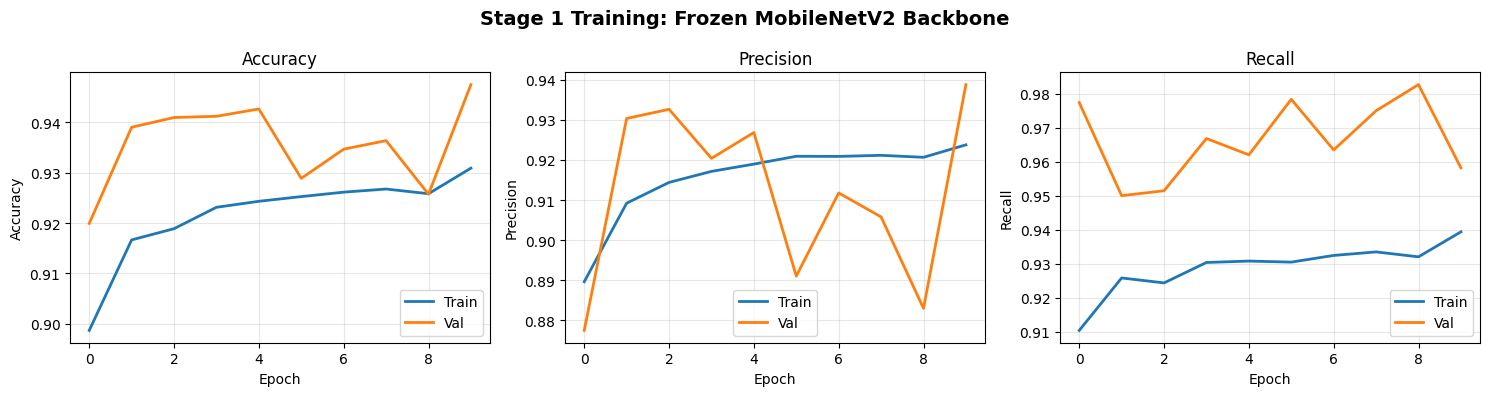


Stage 1 Results:
  Final Train Accuracy: 0.9309
  Final Val Accuracy: 0.9475
  Final Val Precision: 0.9388
  Final Val Recall: 0.9582


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Stage 1 Training: Frozen MobileNetV2 Backbone', fontsize=14, fontweight='bold')

# Accuracy
axes[0].plot(history_stage1.history['accuracy'], label='Train', linewidth=2)
axes[0].plot(history_stage1.history['val_accuracy'], label='Val', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Precision
axes[1].plot(history_stage1.history['precision'], label='Train', linewidth=2)
axes[1].plot(history_stage1.history['val_precision'], label='Val', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Recall
axes[2].plot(history_stage1.history['recall'], label='Train', linewidth=2)
axes[2].plot(history_stage1.history['val_recall'], label='Val', linewidth=2)
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Recall')
axes[2].set_title('Recall')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nStage 1 Results:")
print(f"  Final Train Accuracy: {history_stage1.history['accuracy'][-1]:.4f}")
print(f"  Final Val Accuracy: {history_stage1.history['val_accuracy'][-1]:.4f}")
print(f"  Final Val Precision: {history_stage1.history['val_precision'][-1]:.4f}")
print(f"  Final Val Recall: {history_stage1.history['val_recall'][-1]:.4f}")


In [ ]:
print("\n" + "="*70)
print("STAGE 2: FINE-TUNING")
print("="*70)

# Unfreeze last 30 layers of MobileNetV2
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Count trainable parameters
trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])
print(f"\nUnfreezing last 30 layers of MobileNetV2")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Base model trainable: {base_model.trainable}")
print("="*70)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

print("Model recompiled with learning rate: 5e-4")



STAGE 2: FINE-TUNING

Unfreezing last 30 layers of MobileNetV2
Trainable parameters: 1,690,497
Base model trainable: True
Model recompiled with learning rate: 1e-5


In [ ]:
print("\nTraining Stage 2 (3 epochs)...\n")

history_stage2 = model.fit(
    train_ds_preprocessed,
    validation_data=val_ds_preprocessed,
    epochs=13,
    verbose=1,
    initial_epoch=10
)

print("\n✅ Stage 2 fine-tuning completed!")



Training Stage 2 (3 epochs)...

Epoch 11/13
603/603 ━━━━━━━━━━━━━━━━━━━━ 1206s 2s/step - accuracy: 0.9357 - loss: 0.1939 - precision: 0.9286 - recall: 0.9448 - val_accuracy: 0.9538 - val_loss: 0.4289 - val_precision: 0.9315 - val_recall: 0.9803
Epoch 12/13
603/603 ━━━━━━━━━━━━━━━━━━━━ 1230s 2s/step - accuracy: 0.9593 - loss: 0.1240 - precision: 0.9553 - recall: 0.9641 - val_accuracy: 0.9623 - val_loss: 0.1296 - val_precision: 0.9661 - val_recall: 0.9587
Epoch 13/13
603/603 ━━━━━━━━━━━━━━━━━━━━ 1275s 2s/step - accuracy: 0.9620 - loss: 0.1129 - precision: 0.9585 - recall: 0.9665 - val_accuracy: 0.9644 - val_loss: 0.1498 - val_precision: 0.9654 - val_recall: 0.9640

✅ Stage 2 fine-tuning completed!


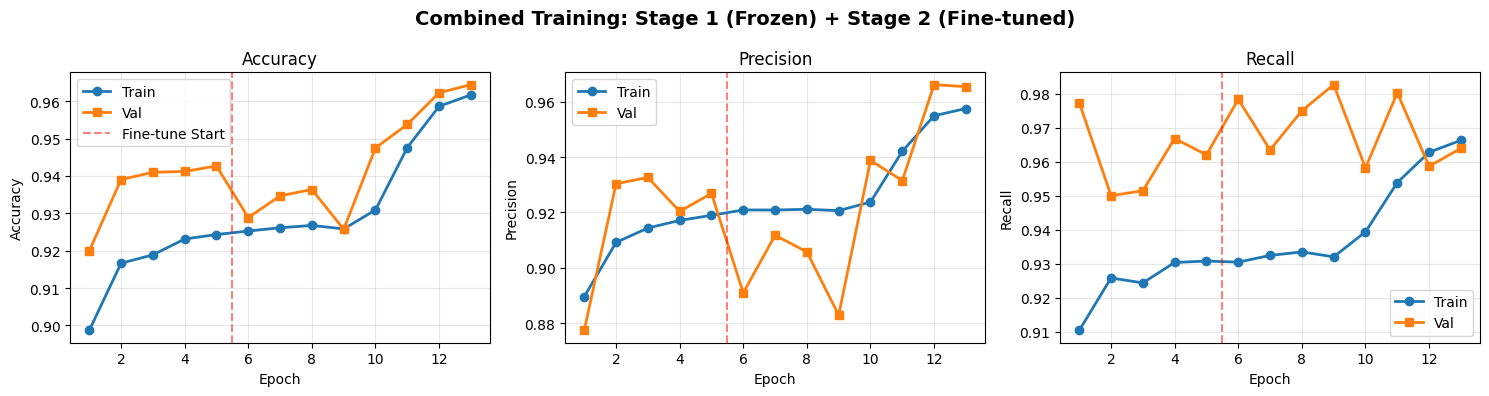

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Combined Training: Stage 1 (Frozen) + Stage 2 (Fine-tuned)',
             fontsize=14, fontweight='bold')

# Accuracy (first subplot)
axes[0].plot(combined_epochs, combined_accuracy, 'o-', label='Train', linewidth=2)
axes[0].plot(combined_epochs, combined_val_accuracy, 's-', label='Val', linewidth=2)
axes[0].axvline(x=5.5, color='red', linestyle='--', alpha=0.5, label='Fine-tune Start')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Precision (second subplot)
axes[1].plot(combined_epochs, combined_precision, 'o-', label='Train', linewidth=2)
axes[1].plot(combined_epochs, combined_val_precision, 's-', label='Val', linewidth=2)
axes[1].axvline(x=5.5, color='red', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Recall (third subplot)
axes[2].plot(combined_epochs, combined_recall, 'o-', label='Train', linewidth=2)
axes[2].plot(combined_epochs, combined_val_recall, 's-', label='Val', linewidth=2)
axes[2].axvline(x=5.5, color='red', linestyle='--', alpha=0.5)
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Recall')
axes[2].set_title('Recall')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [23]:
print("\n" + "="*70)
print("TEST SET EVALUATION")
print("="*70 + "\n")

# Collect predictions and true labels from test set
all_predictions = []
all_labels = []

for images, labels in test_ds_preprocessed:
    logits = model.predict(images, verbose=0)
    predictions = (logits > 0.5).astype(int).flatten()

    all_predictions.extend(predictions)
    all_labels.extend(labels.numpy())

all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

print(f"✅ Generated predictions for {len(all_labels)} test samples")



TEST SET EVALUATION

✅ Generated predictions for 4134 test samples


In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

print("\n" + "="*70)
print("TEST SET METRICS")
print("="*70)
print(f"Accuracy:  {accuracy:.4f} ({100*accuracy:.2f}%)")
print(f"Precision: {precision:.4f} ({100*precision:.2f}%)")
print(f"Recall:    {recall:.4f} ({100*recall:.2f}%)")
print(f"F1-Score:  {f1:.4f}")
print("="*70)

print(f"\n📊 Interpretation:")
print(f"  • Accuracy: {100*accuracy:.1f}% of predictions are correct")
print(f"  • Precision: {100*precision:.1f}% of 'Infected' predictions are correct (few false positives)")
print(f"  • Recall: {100*recall:.1f}% of actual 'Infected' cases are caught (few false negatives)")
print(f"  • F1: Harmonic mean of precision and recall")



TEST SET METRICS
Accuracy:  0.9635 (96.35%)
Precision: 0.9593 (95.93%)
Recall:    0.9673 (96.73%)
F1-Score:  0.9633

📊 Interpretation:
  • Accuracy: 96.3% of predictions are correct
  • Precision: 95.9% of 'Infected' predictions are correct (few false positives)
  • Recall: 96.7% of actual 'Infected' cases are caught (few false negatives)
  • F1: Harmonic mean of precision and recall


In [25]:
print("\n" + "="*70)
print("DETAILED CLASSIFICATION REPORT")
print("="*70 + "\n")

report = classification_report(
    all_labels,
    all_predictions,
    target_names=['Uninfected', 'Infected'],
    digits=4
)
print(report)



DETAILED CLASSIFICATION REPORT

              precision    recall  f1-score   support

  Uninfected     0.9676    0.9597    0.9637      2086
    Infected     0.9593    0.9673    0.9633      2048

    accuracy                         0.9635      4134
   macro avg     0.9635    0.9635    0.9635      4134
weighted avg     0.9635    0.9635    0.9635      4134



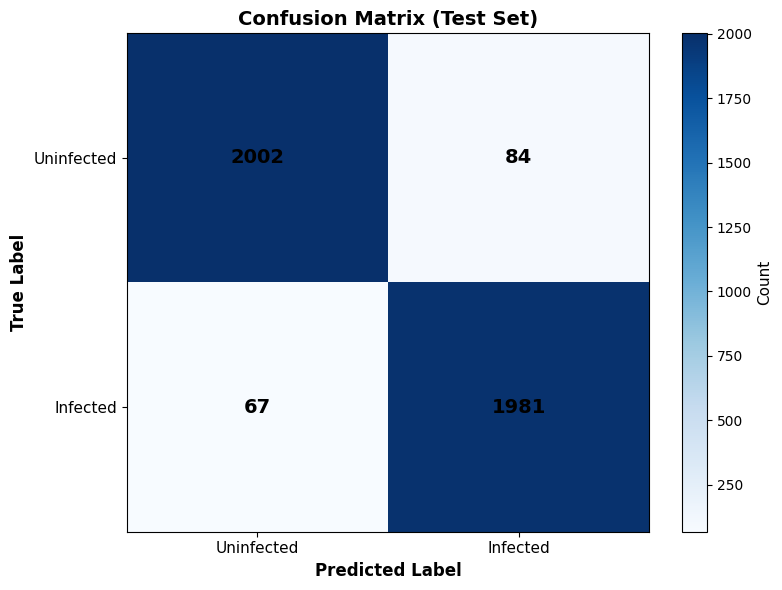


Confusion Matrix Analysis:
  True Negatives (TN): 2,002 — Correctly identified uninfected
  False Positives (FP): 84 — Incorrectly flagged as infected
  False Negatives (FN): 67 — Missed infected cases (⚠️ critical)
  True Positives (TP): 1,981 — Correctly identified infected


In [26]:
cm = confusion_matrix(all_labels, all_predictions)

fig, ax = plt.subplots(figsize=(8, 6))

# Create heatmap
im = ax.imshow(cm, cmap='Blues', aspect='auto')

# Add text annotations
for i in range(2):
    for j in range(2):
        text = ax.text(j, i, cm[i, j],
                      ha="center", va="center", color="black", fontsize=14, fontweight='bold')

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Uninfected', 'Infected'], fontsize=11)
ax.set_yticklabels(['Uninfected', 'Infected'], fontsize=11)
ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax.set_title('Confusion Matrix (Test Set)', fontsize=14, fontweight='bold')

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Count', fontsize=11)

plt.tight_layout()
plt.show()

print("\nConfusion Matrix Analysis:")
print(f"  True Negatives (TN): {cm[0, 0]:,} — Correctly identified uninfected")
print(f"  False Positives (FP): {cm[0, 1]:,} — Incorrectly flagged as infected")
print(f"  False Negatives (FN): {cm[1, 0]:,} — Missed infected cases (⚠️ critical)")
print(f"  True Positives (TP): {cm[1, 1]:,} — Correctly identified infected")



⚠️ Misclassified Samples: 151 / 4134
Misclassification Rate: 3.65%

Showing up to 8 misclassified examples:


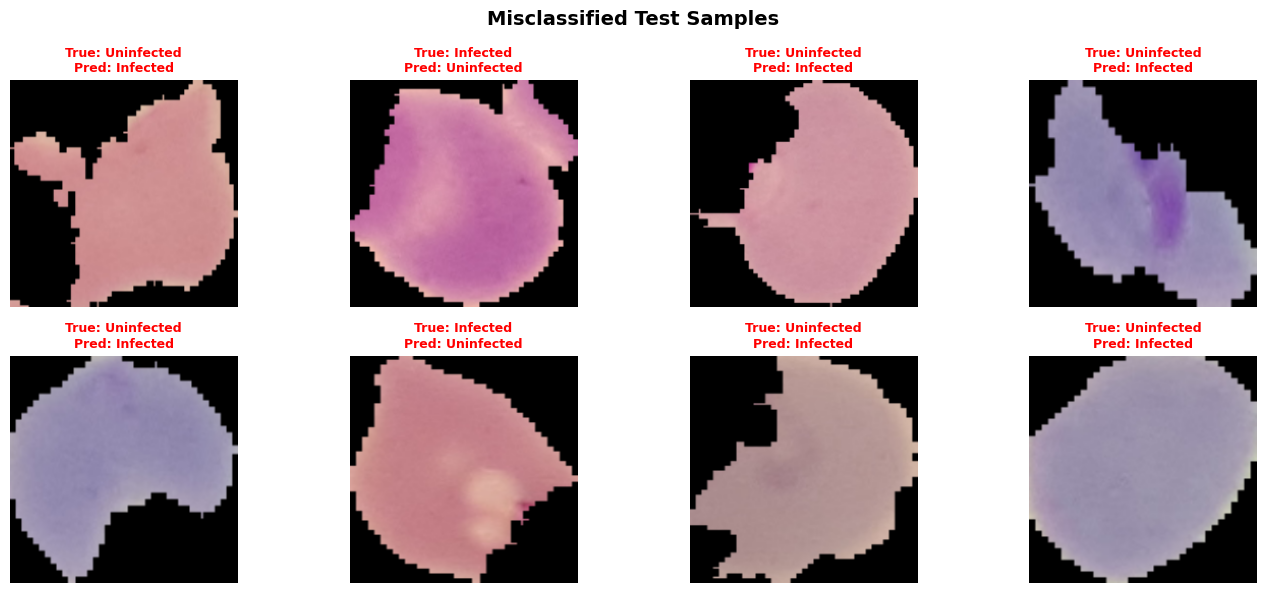

In [35]:
# 1) Get integer indices of misclassified samples
misclassified_indices = np.where(all_predictions != all_labels)[0]

print(f"\n⚠️ Misclassified Samples: {len(misclassified_indices)} / {len(all_labels)}")
print(f"Misclassification Rate: {100 * len(misclassified_indices) / len(all_labels):.2f}%\n")

if len(misclassified_indices) > 0:
    print("Showing up to 8 misclassified examples:")

    fig, axes = plt.subplots(2, 4, figsize=(14, 6))
    fig.suptitle('Misclassified Test Samples', fontsize=14, fontweight='bold')

    for idx, misclass_idx in enumerate(misclassified_indices[:8]):
        ax = axes[idx // 4, idx % 4]

        # Reconstruct image from test set
        for i, (images, labels) in enumerate(test_ds_preprocessed):
            if misclass_idx < (i + 1) * BATCH_SIZE:
                img = images[misclass_idx % BATCH_SIZE]
                img_to_show = tf.clip_by_value(img, 0.0, 255.0)
                img_to_show = tf.cast(img_to_show, tf.uint8)

                true_label = all_labels[misclass_idx]
                pred_label = all_predictions[misclass_idx]

                ax.imshow(img_to_show.numpy())
                true_text = "Infected" if true_label == 1 else "Uninfected"
                pred_text = "Infected" if pred_label == 1 else "Uninfected"
                title = f"True: {true_text}\nPred: {pred_text}"
                ax.set_title(title, fontsize=9, color='red', fontweight='bold')
                ax.axis('off')
                break

    plt.tight_layout()
    plt.show()
else:
    print("🎉 Perfect! No misclassifications on test set!")


